In [47]:
# %pip install PyMySQL
# %pip install pandas
# %pip install cryptography
# %pip install torch torchvision torchaudio

# 터미널에서 mysql에 사용자 추가하는 법
# mysql> CREATE user '사용자'@'localhost' IDENTIFIED BY '사용자_비밀번호';
# mysql> GRANT ALL PRIVILEGES ON *.* to '사용자'@'localhost'; # 모든 DB에 접근 가능 *.*
# mysql> FLUSH PRIVILEGES; # 새로운 세팅 적용
# 참고:http://bigdata.dongguk.ac.kr/lectures/DB/_book/python%EC%97%90%EC%84%9C-mysql%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%9D%98-%EC%A0%91%EA%B7%BC.html

import pymysql
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [48]:
con = pymysql.connect(host='localhost', user= 'kevinmj12', password='kookbop', db='kookbop', charset='utf8') # mysql connection 연결
cur = con.cursor() # connection으로부터 cursor 생성

sql = "SELECT * FROM review" 
cur.execute(sql) # sql문 실행

rows = cur.fetchall()
data = pd.DataFrame(rows)
testData = pd.DataFrame(rows)
data

,0,1,2,3,4,5,6,7,8
0,99,jongbin,1,묵채비빔밥,2022-11-11,5.0,0,맛있어요!,None
1,100,jongbin,2,파채부대덮밥,2022-11-11,4.0,0,맛있나요?,None


In [49]:
menus = torch.LongTensor(data[2])
users = torch.LongTensor(data[0]-98) # userId가 99, 100으로 되어 있어 98 뺌
ratings = torch.FloatTensor(data[5])
menusTest = torch.LongTensor(testData[2])
usersTest = torch.LongTensor(testData[0]-98)
ratingsTest = torch.FloatTensor(testData[5])
users

tensor([1, 2])

In [50]:
rank = 10
numMenus = menus.max()+1
numUsers = users.max()+1 
P = torch.randn(numMenus, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
biasMenu = torch.randn(numMenus, requires_grad=True)
biasUser = torch.randn(numUsers, requires_grad = True)
mean = ratings.mean()

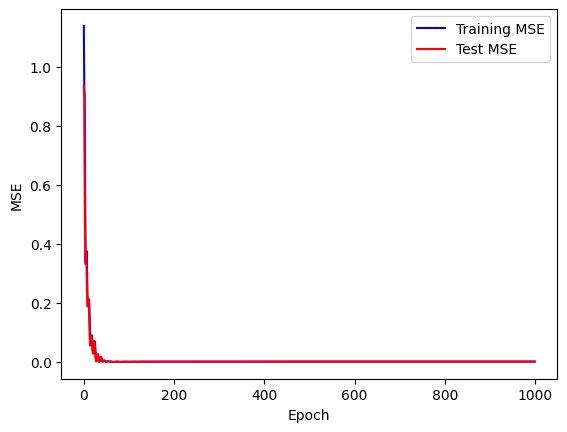

In [51]:
optim = torch.optim.Adam([P, Q, biasMenu, biasUser], lr = 0.1)

lambda1 = 0.5
lambda2 = 0.5
lambda3 = 0.5
lambda4 = 0.5


X = []
Y = []
Y_test = []

for epoch in range(1000):
  h = (P[menus] *Q[users]).sum(dim=1) + mean + biasMenu[menus] + biasUser[users]
  cost = F.mse_loss(h, ratings)
  loss = cost + lambda1*(P**2).mean() + lambda2*(Q**2).mean() \
  + lambda3*(biasUser**2).mean() + lambda4*(biasMenu**2).mean()

  optim.zero_grad()
  loss.backward()
  optim.step()

  X.append(epoch)
  Y.append(cost.item())
  with torch.no_grad():
    h_test = (P[menusTest] * Q[usersTest]).sum(dim=1) + mean + biasMenu[menusTest] + biasUser[usersTest]
    cost_test = F.mse_loss(h_test, ratingsTest);
    Y_test.append(cost_test.item())
  
  # with torch.no_grad():
    # if epoch % 100 == 0:
      # print(f"epoch: {epoch}, cost: {cost.item()}, cost_test: {cost_test.item()}\n h:{h}")

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.plot(X, Y, c="blue", label = "Training MSE")
plt.plot(X, Y_test, c="red", label = "Test MSE")
plt.legend()
plt.show()

In [52]:

resultMatrix = torch.transpose(torch.mm(P,torch.transpose(Q,0,1))[1:]+mean+biasMenu+biasUser, 0, 1)[1:]

print(resultMatrix)
data

# tensor([[4.9667, 4.7307],
#        [4.2693, 4.0333]], grad_fn=<SliceBackward0>)
# 와 같이 나올텐데 행은 유저, 열은 메뉴로 99번유저의 묵채비빔밥은 4.9667점, 파채부대덮밥은 4.7307점
# 100번 유저의 묵채비빔밥은 4.2693점, 파채부대덮밥은 4.0333점을 예측함.

tensor([[4.9667, 4.7307],
        [4.2693, 4.0333]], grad_fn=<SliceBackward0>)


,0,1,2,3,4,5,6,7,8
0,99,jongbin,1,묵채비빔밥,2022-11-11,5.0,0,맛있어요!,None
1,100,jongbin,2,파채부대덮밥,2022-11-11,4.0,0,맛있나요?,None
